https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

Load dataset from directory "Documents", Split (Train(15%:Validate)) 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import os
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torchsummary import summary
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
import cv2
from tqdm import tqdm

In [2]:
#reproducibility
'''random_seed = 42
torch.manual_seed(random_seed)'''

data_dir = r'C:\Users\AFIFI FAIZ\Documents\Brain Tumor'

# Load train
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'))

# Split train
train_size = int(0.80 * len(train_dataset))
val_size = len(train_dataset) - train_size#split validate

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Load test 
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Testing'))

In [3]:

image, label = train_dataset.dataset[0]  # first image - 0
print(f"Original image dimensions: {image.size}") # original dimension

# category
categories_train = train_dataset.dataset.classes
# index of category
class_to_idx = train_dataset.dataset.class_to_idx

# category and index
categories_with_indices = [f"{category} ({index})" for category, index in class_to_idx.items()]


print("Categories with Index:")
print(", ".join(categories_with_indices))
    

Original image dimensions: (512, 512)
Categories with Index:
glioma (0), meningioma (1), notumor (2), pituitary (3)


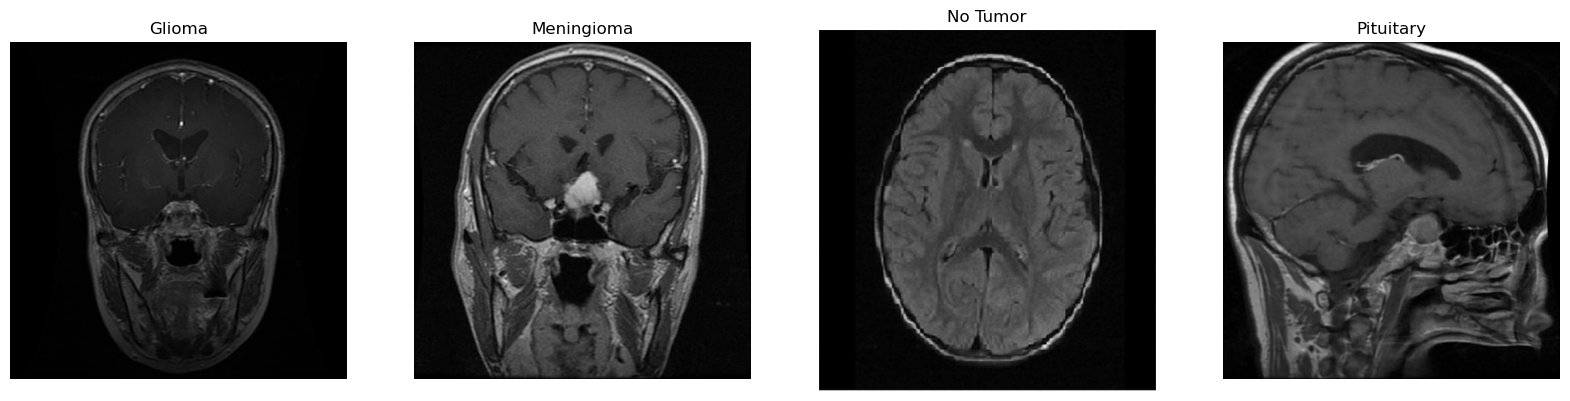

In [4]:
# class index
class_indices = {
    'glioma': train_dataset.dataset.class_to_idx['glioma'],
    'meningioma': train_dataset.dataset.class_to_idx['meningioma'],
    'notumor': train_dataset.dataset.class_to_idx['notumor'],
    'pituitary': train_dataset.dataset.class_to_idx['pituitary']
}


glioma_images = [(image, label) for image, label in train_dataset if label == class_indices['glioma']]
meningioma_images = [(image, label) for image, label in train_dataset if label == class_indices['meningioma']]
notumor_images = [(image, label) for image, label in train_dataset if label == class_indices['notumor']]
pituitary_images = [(image, label) for image, label in train_dataset if label == class_indices['pituitary']]


images = [glioma_images[0][0], meningioma_images[0][0], notumor_images[0][0], pituitary_images[0][0]]
titles = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Plot in one row, four column
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(titles[i])
    ax.axis('off')

plt.show()


Training data Distribution

In [5]:
# total training
print("Total number of Training data: ", len(train_dataset))


class_counts = Counter([label for _, label in train_dataset])


class_names = train_dataset.dataset.classes
for class_idx, count in class_counts.items():
    print(f"Total number of images in class '{class_names[class_idx]}': {count}")

Total number of Training data:  4569
Total number of images in class 'notumor': 1310
Total number of images in class 'glioma': 1051
Total number of images in class 'meningioma': 1055
Total number of images in class 'pituitary': 1153


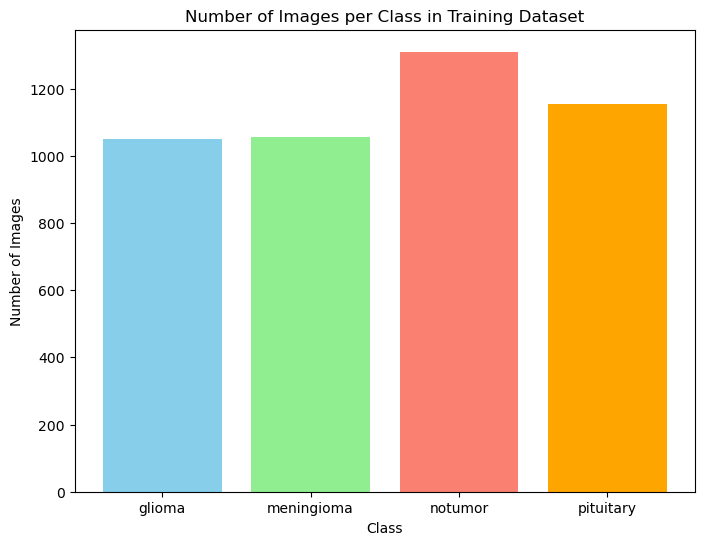

In [6]:

class_names_with_counts = [class_names[class_idx] for class_idx in range(len(class_names))]
counts = [class_counts[class_idx] for class_idx in range(len(class_names))]


colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

plt.figure(figsize=(8, 6))
plt.bar(class_names_with_counts, counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Dataset')
plt.show()

Validation data Distribution

In [7]:
# total validation
print("Total number of Validation data: ", len(val_dataset))


class_counts = Counter([label for _, label in val_dataset])


class_names = val_dataset.dataset.classes
for class_idx, count in class_counts.items():
    print(f"Total number of images in class '{class_names[class_idx]}': {count}")

Total number of Validation data:  1143
Total number of images in class 'meningioma': 284
Total number of images in class 'glioma': 270
Total number of images in class 'pituitary': 304
Total number of images in class 'notumor': 285


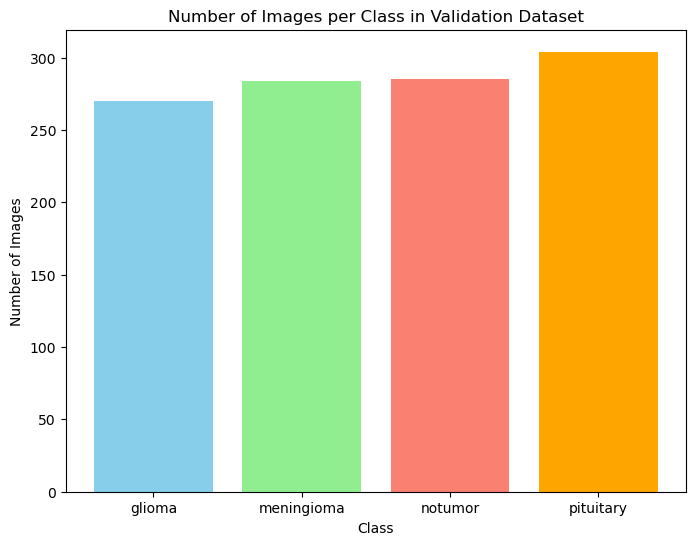

In [8]:

class_names_with_counts = [class_names[class_idx] for class_idx in range(len(class_names))]
counts = [class_counts[class_idx] for class_idx in range(len(class_names))]


colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

plt.figure(figsize=(8, 6))
plt.bar(class_names_with_counts, counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Validation Dataset')
plt.show()

Testing data Distribution

In [9]:
# total test
print("Total number of Validation data: ", len(test_dataset))


class_counts = Counter([label for _, label in test_dataset])


class_names = test_dataset.classes
for class_idx, count in class_counts.items():
    print(f"Total number of images in class '{class_names[class_idx]}': {count}")

Total number of Validation data:  1311
Total number of images in class 'glioma': 300
Total number of images in class 'meningioma': 306
Total number of images in class 'notumor': 405
Total number of images in class 'pituitary': 300


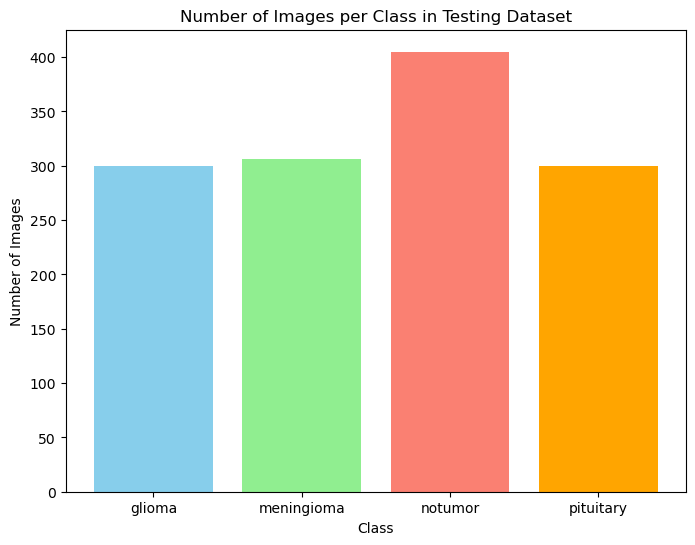

In [10]:

class_names_with_counts = [class_names[class_idx] for class_idx in range(len(class_names))]
counts = [class_counts[class_idx] for class_idx in range(len(class_names))]


colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

plt.figure(figsize=(8, 6))
plt.bar(class_names_with_counts, counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Testing Dataset')
plt.show()

Transform and Augmented Data

In [11]:
#augment
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),  # Adding vertical flip
        transforms.RandomRotation(10),#/5
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Slight translation (look left up something)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #equal to 1(default value of resnet)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Apply transformations
transformed_train_dataset = [(data_transforms['train'](image), label) for image, label in train_dataset]
transformed_val_dataset = [(data_transforms['test'](image), label) for image, label in val_dataset]
transformed_test_dataset = [(data_transforms['test'](image), label) for image, label in val_dataset]

#prepare data for training/valid/test phase
train_loader = DataLoader(transformed_train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(transformed_val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(transformed_test_dataset, batch_size=32, shuffle=True, num_workers=4)

# new dimension after transform
print("New dimensions image of dataset:")
print(transformed_train_dataset[0][0].shape)  # (C, H, W)


New dimensions image of dataset:
torch.Size([3, 224, 224])


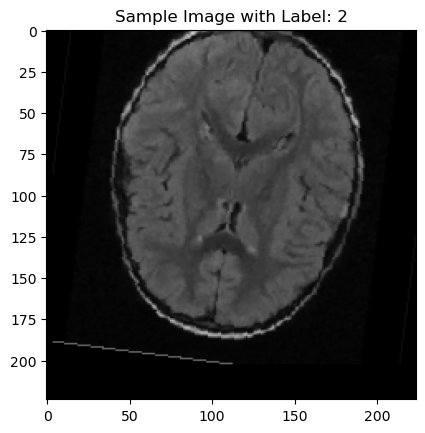

In [12]:

sample_image, sample_label = transformed_train_dataset[0]

# tensor image back to format can display
sample_image = sample_image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
sample_image = sample_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize

plt.imshow(np.clip(sample_image, 0, 1))
plt.title(f"Sample Image with Label: {sample_label}")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


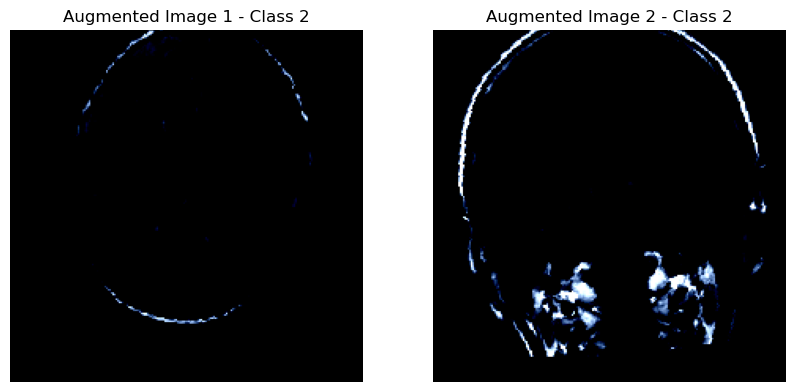

In [13]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


image1, label1 = transformed_train_dataset[0]
image1 = image1.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C) for displaying
axes[0].imshow(image1.numpy())
axes[0].set_title(f"Augmented Image 1 - Class {label1}")
axes[0].axis('off')


image2, label2 = transformed_train_dataset[1]
image2 = image2.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C) for displaying
axes[1].imshow(image2.numpy())
axes[1].set_title(f"Augmented Image 2 - Class {label2}")
axes[1].axis('off')

plt.show()

Build Resnet50 by freezing all layer and unfreeze some for the resnet to learn on my data (use only output layer as new layer on resnet) 

In [14]:
image_size = 224
#batch_size = 32#/16
num_workers = 2
learning_rate = 0.000001#0.0001
num_epochs = 25

In [15]:


num_class = 4

class CNNModel(nn.Module):
    
    def __init__(self, image_depth):
        super(CNNModel, self).__init__()
        
        # Load the pre-trained ResNet-50 model
        self.resnet = models.resnet50(pretrained=True)
        
        # Freeze all layers in the ResNet model initially
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Get the list of layers in the ResNet model
        layers = list(self.resnet.children())
        
        # Unfreeze the last 3 blocks 
        for layer in layers[-3:]:
            for param in layer.parameters():
                param.requires_grad = True
        ##Add a dropout layer before the final fully connected layer
        #self.resnet.dropout = nn.Dropout(p=0.5)  # Dropout with a probability of 0.5
        
        # Replace the last fully connected layer with a new one with `num_class` outputs
        self.resnet.fc = nn.Linear(in_features=self.resnet.fc.in_features, out_features=num_class)
        
        # Ensure that the final fully connected layer is trainable
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        # Use the ResNet model for feature extraction
        x = self.resnet(x)
        return x
model = CNNModel(image_depth=3)

# Print the model to verify the changes
print(model)

c:\Users\AFIFI FAIZ\anaconda3\envs\AINusan\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AFIFI FAIZ\anaconda3\envs\AINusan\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [16]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Train the Resnet and add modelcheckpoint and early stopping, save the weight of model

In [17]:
'''
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer with weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=5e-5)

# Learning rate scheduler for adaptive learning rate
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Directory to save model weights in the "Documents" folder
save_dir = os.path.join(os.path.expanduser("~"), "Documents", "model_weights_new")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# File path for saving the best model
checkpoint_path = os.path.join(save_dir, "best_model.pth.tar")

# Training loop
best_val_accuracy = 0

for epoch_idx in range(num_epochs):

    model.train()  # Set the model to training mode
    train_running_loss = 0.0
    train_running_accuracy = 0.0

    for idx, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, labels = data

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        train_running_loss += loss.item()

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).sum().item()
        train_running_accuracy += correct / labels.size(0)

    # Print training results for this epoch
    print(f"Epoch [{epoch_idx + 1}/{num_epochs}] - Training Loss: {train_running_loss / len(train_loader):.4f}, "
          f"Training Accuracy: {train_running_accuracy / len(train_loader):.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():
        for idx, data in tqdm(enumerate(val_loader), total=len(val_loader)):
            images, labels = data

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct = (preds == labels).sum().item()
            val_running_accuracy += correct / labels.size(0)

    # Calculate validation accuracy
    val_accuracy = val_running_accuracy / len(val_loader)
    val_loss = val_running_loss / len(val_loader)
    
    # Print validation results for this epoch
    print(f"Epoch [{epoch_idx + 1}/{num_epochs}] - Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Check if this is the best validation accuracy we've seen so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

        # Save the model (overwrite the existing file)
        torch.save(model.state_dict(), os.path.join(save_dir, f"saved_model-{epoch_idx + 1}.pth.tar"))
        print(f"Model saved at epoch {epoch_idx + 1} with validation accuracy of {best_val_accuracy:.4f}")
    
    # Adjust learning rate based on validation loss
    #scheduler.step(val_loss)
    '''

    

'\n# Define loss function\nloss_fn = nn.CrossEntropyLoss()\n\n# Define optimizer with weight decay for L2 regularization\noptimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=5e-5)\n\n# Learning rate scheduler for adaptive learning rate\n#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=\'min\', factor=0.5, patience=3, verbose=True)\n\n# Directory to save model weights in the "Documents" folder\nsave_dir = os.path.join(os.path.expanduser("~"), "Documents", "model_weights_new")\nif not os.path.exists(save_dir):\n    os.makedirs(save_dir)\n\n# File path for saving the best model\ncheckpoint_path = os.path.join(save_dir, "best_model.pth.tar")\n\n# Training loop\nbest_val_accuracy = 0\n\nfor epoch_idx in range(num_epochs):\n\n    model.train()  # Set the model to training mode\n    train_running_loss = 0.0\n    train_running_accuracy = 0.0\n\n    for idx, data in tqdm(enumerate(train_loader), total=len(train_loader)):\n        images, labels = data\n\n

History of epoch on the last run (model_weights_new) file

100%|██████████| 143/143 [11:18<00:00,  4.74s/it]
Epoch [1/25] - Training Loss: 1.2900, Training Accuracy: 0.4318
100%|██████████| 36/36 [01:47<00:00,  2.99s/it]
Epoch [1/25] - Validation Loss: 1.1893, Validation Accuracy: 0.5303
Model saved at epoch 1 with validation accuracy of 0.5303
100%|██████████| 143/143 [10:30<00:00,  4.41s/it]
Epoch [2/25] - Training Loss: 1.0887, Training Accuracy: 0.6104
100%|██████████| 36/36 [01:46<00:00,  2.95s/it]
Epoch [2/25] - Validation Loss: 1.0149, Validation Accuracy: 0.6627
Model saved at epoch 2 with validation accuracy of 0.6627
100%|██████████| 143/143 [10:17<00:00,  4.32s/it]
Epoch [3/25] - Training Loss: 0.9253, Training Accuracy: 0.7142
100%|██████████| 36/36 [01:36<00:00,  2.68s/it]
Epoch [3/25] - Validation Loss: 0.8753, Validation Accuracy: 0.7579
Model saved at epoch 3 with validation accuracy of 0.7579
100%|██████████| 143/143 [10:14<00:00,  4.30s/it]
Epoch [4/25] - Training Loss: 0.7935, Training Accuracy: 0.7828
100%|██████████| 36/36 [01:38<00:00,  2.74s/it]
Epoch [4/25] - Validation Loss: 0.7598, Validation Accuracy: 0.8091
Model saved at epoch 4 with validation accuracy of 0.8091
100%|██████████| 143/143 [10:58<00:00,  4.60s/it]
Epoch [5/25] - Training Loss: 0.6872, Training Accuracy: 0.8244
100%|██████████| 36/36 [02:11<00:00,  3.66s/it]
Epoch [5/25] - Validation Loss: 0.6717, Validation Accuracy: 0.8360
Model saved at epoch 5 with validation accuracy of 0.8360
100%|██████████| 143/143 [12:02<00:00,  5.05s/it]
Epoch [6/25] - Training Loss: 0.6039, Training Accuracy: 0.8394
100%|██████████| 36/36 [02:03<00:00,  3.42s/it]
Epoch [6/25] - Validation Loss: 0.5962, Validation Accuracy: 0.8512
Model saved at epoch 6 with validation accuracy of 0.8512
100%|██████████| 143/143 [11:06<00:00,  4.66s/it]
Epoch [7/25] - Training Loss: 0.5339, Training Accuracy: 0.8578
100%|██████████| 36/36 [01:56<00:00,  3.24s/it]
Epoch [7/25] - Validation Loss: 0.5395, Validation Accuracy: 0.8636
Model saved at epoch 7 with validation accuracy of 0.8636
100%|██████████| 143/143 [10:10<00:00,  4.27s/it]
Epoch [8/25] - Training Loss: 0.4815, Training Accuracy: 0.8679
100%|██████████| 36/36 [01:54<00:00,  3.18s/it]
Epoch [8/25] - Validation Loss: 0.4782, Validation Accuracy: 0.8686
Model saved at epoch 8 with validation accuracy of 0.8686
100%|██████████| 143/143 [16:45<00:00,  7.03s/it]
Epoch [9/25] - Training Loss: 0.4394, Training Accuracy: 0.8761
100%|██████████| 36/36 [07:45<00:00, 12.94s/it]
Epoch [9/25] - Validation Loss: 0.4487, Validation Accuracy: 0.8738
Model saved at epoch 9 with validation accuracy of 0.8738
100%|██████████| 143/143 [30:56<00:00, 12.98s/it]
Epoch [10/25] - Training Loss: 0.3996, Training Accuracy: 0.8860
100%|██████████| 36/36 [02:13<00:00,  3.70s/it]
Epoch [10/25] - Validation Loss: 0.4187, Validation Accuracy: 0.8804
Model saved at epoch 10 with validation accuracy of 0.8804
100%|██████████| 143/143 [12:30<00:00,  5.25s/it]
Epoch [11/25] - Training Loss: 0.3722, Training Accuracy: 0.8895
100%|██████████| 36/36 [02:11<00:00,  3.65s/it]
Epoch [11/25] - Validation Loss: 0.3973, Validation Accuracy: 0.8776
100%|██████████| 143/143 [11:54<00:00,  4.99s/it]
Epoch [12/25] - Training Loss: 0.3478, Training Accuracy: 0.8950
100%|██████████| 36/36 [02:00<00:00,  3.34s/it]
Epoch [12/25] - Validation Loss: 0.3698, Validation Accuracy: 0.8910
Model saved at epoch 12 with validation accuracy of 0.8910
100%|██████████| 143/143 [11:11<00:00,  4.69s/it]
Epoch [13/25] - Training Loss: 0.3213, Training Accuracy: 0.9024
100%|██████████| 36/36 [01:59<00:00,  3.32s/it]
Epoch [13/25] - Validation Loss: 0.3458, Validation Accuracy: 0.8974
Model saved at epoch 13 with validation accuracy of 0.8974
100%|██████████| 143/143 [11:38<00:00,  4.88s/it]
Epoch [14/25] - Training Loss: 0.3037, Training Accuracy: 0.9081
100%|██████████| 36/36 [02:00<00:00,  3.36s/it]
Epoch [14/25] - Validation Loss: 0.3434, Validation Accuracy: 0.8948
100%|██████████| 143/143 [11:27<00:00,  4.81s/it]
Epoch [15/25] - Training Loss: 0.2914, Training Accuracy: 0.9102
100%|██████████| 36/36 [01:59<00:00,  3.31s/it]
Epoch [15/25] - Validation Loss: 0.3175, Validation Accuracy: 0.9044
Model saved at epoch 15 with validation accuracy of 0.9044
100%|██████████| 143/143 [11:20<00:00,  4.76s/it]
Epoch [16/25] - Training Loss: 0.2622, Training Accuracy: 0.9205
100%|██████████| 36/36 [01:58<00:00,  3.30s/it]
Epoch [16/25] - Validation Loss: 0.3041, Validation Accuracy: 0.9054
Model saved at epoch 16 with validation accuracy of 0.9054
100%|██████████| 143/143 [11:22<00:00,  4.78s/it]
Epoch [17/25] - Training Loss: 0.2506, Training Accuracy: 0.9231
100%|██████████| 36/36 [01:59<00:00,  3.32s/it]
Epoch [17/25] - Validation Loss: 0.2977, Validation Accuracy: 0.9080
Model saved at epoch 17 with validation accuracy of 0.9080
100%|██████████| 143/143 [11:21<00:00,  4.77s/it]
Epoch [18/25] - Training Loss: 0.2408, Training Accuracy: 0.9258
100%|██████████| 36/36 [02:01<00:00,  3.38s/it]
Epoch [18/25] - Validation Loss: 0.2826, Validation Accuracy: 0.9160
Model saved at epoch 18 with validation accuracy of 0.9160
100%|██████████| 143/143 [12:21<00:00,  5.19s/it]
Epoch [19/25] - Training Loss: 0.2245, Training Accuracy: 0.9335
100%|██████████| 36/36 [02:20<00:00,  3.91s/it]
Epoch [19/25] - Validation Loss: 0.2831, Validation Accuracy: 0.9096
100%|██████████| 143/143 [12:14<00:00,  5.14s/it]
Epoch [20/25] - Training Loss: 0.2109, Training Accuracy: 0.9337
100%|██████████| 36/36 [02:08<00:00,  3.56s/it]
Epoch [20/25] - Validation Loss: 0.2728, Validation Accuracy: 0.9129
100%|██████████| 143/143 [11:38<00:00,  4.89s/it]
Epoch [21/25] - Training Loss: 0.1963, Training Accuracy: 0.9389
100%|██████████| 36/36 [02:03<00:00,  3.42s/it]
Epoch [21/25] - Validation Loss: 0.2582, Validation Accuracy: 0.9177
Model saved at epoch 21 with validation accuracy of 0.9177
100%|██████████| 143/143 [11:43<00:00,  4.92s/it]
Epoch [22/25] - Training Loss: 0.1885, Training Accuracy: 0.9439
100%|██████████| 36/36 [01:55<00:00,  3.22s/it]
Epoch [22/25] - Validation Loss: 0.2473, Validation Accuracy: 0.9212
Model saved at epoch 22 with validation accuracy of 0.9212
100%|██████████| 143/143 [11:02<00:00,  4.63s/it]
Epoch [23/25] - Training Loss: 0.1801, Training Accuracy: 0.9473
100%|██████████| 36/36 [01:30<00:00,  2.50s/it]
Epoch [23/25] - Validation Loss: 0.2500, Validation Accuracy: 0.9174
100%|██████████| 143/143 [10:01<00:00,  4.21s/it]
Epoch [24/25] - Training Loss: 0.1702, Training Accuracy: 0.9466
100%|██████████| 36/36 [02:01<00:00,  3.37s/it]
Epoch [24/25] - Validation Loss: 0.2385, Validation Accuracy: 0.9203
100%|██████████| 143/143 [10:16<00:00,  4.31s/it]
Epoch [25/25] - Training Loss: 0.1611, Training Accuracy: 0.9560
100%|██████████| 36/36 [01:48<00:00,  3.02s/it]
Epoch [25/25] - Validation Loss: 0.2355, Validation Accuracy: 0.9264
Model saved at epoch 25 with validation accuracy of 0.9264


In [18]:

# Path saved model
checkpoint_path = os.path.join(os.path.expanduser("~"), "Documents", "model_weights_new", "saved_model-25.pth.tar")

# Load weights to the model
model.load_state_dict(torch.load(checkpoint_path))

model.eval()

C:\Users\AFIFI FAIZ\AppData\Local\Temp\ipykernel_6860\2318372271.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


CNNModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [19]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation 
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 92.74%


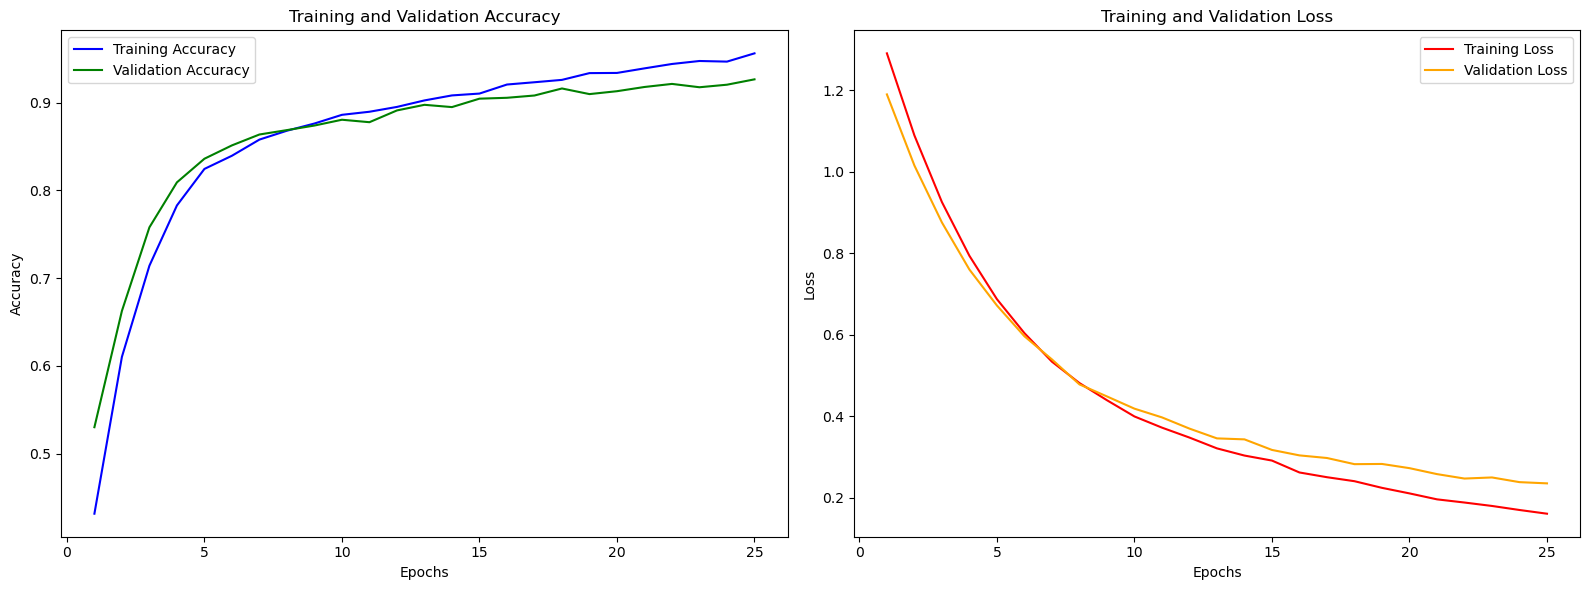

In [20]:
train_accuracies = [
    0.4318, 0.6104, 0.7142, 0.7828, 0.8244, 0.8394, 0.8578, 0.8679, 
    0.8761, 0.8860, 0.8895, 0.8950, 0.9024, 0.9081, 0.9102, 0.9205, 
    0.9231, 0.9258, 0.9335, 0.9337, 0.9389, 0.9439, 0.9473, 0.9466, 0.9560
]
val_accuracies = [
    0.5303, 0.6627, 0.7579, 0.8091, 0.8360, 0.8512, 0.8636, 0.8686, 
    0.8738, 0.8804, 0.8776, 0.8910, 0.8974, 0.8948, 0.9044, 0.9054, 
    0.9080, 0.9160, 0.9096, 0.9129, 0.9177, 0.9212, 0.9174, 0.9203, 0.9264
]
train_losses = [
    1.2900, 1.0887, 0.9253, 0.7935, 0.6872, 0.6039, 0.5339, 0.4815, 
    0.4394, 0.3996, 0.3722, 0.3478, 0.3213, 0.3037, 0.2914, 0.2622, 
    0.2506, 0.2408, 0.2245, 0.2109, 0.1963, 0.1885, 0.1801, 0.1702, 0.1611
]
val_losses = [
    1.1893, 1.0149, 0.8753, 0.7598, 0.6717, 0.5962, 0.5395, 0.4782, 
    0.4487, 0.4187, 0.3973, 0.3698, 0.3458, 0.3434, 0.3175, 0.3041, 
    0.2977, 0.2826, 0.2831, 0.2728, 0.2582, 0.2473, 0.2500, 0.2385, 0.2355
]
num_epochs = len(train_accuracies)


plt.figure(figsize=(16, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='red')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



add f1 score , classification report, confusion matrix

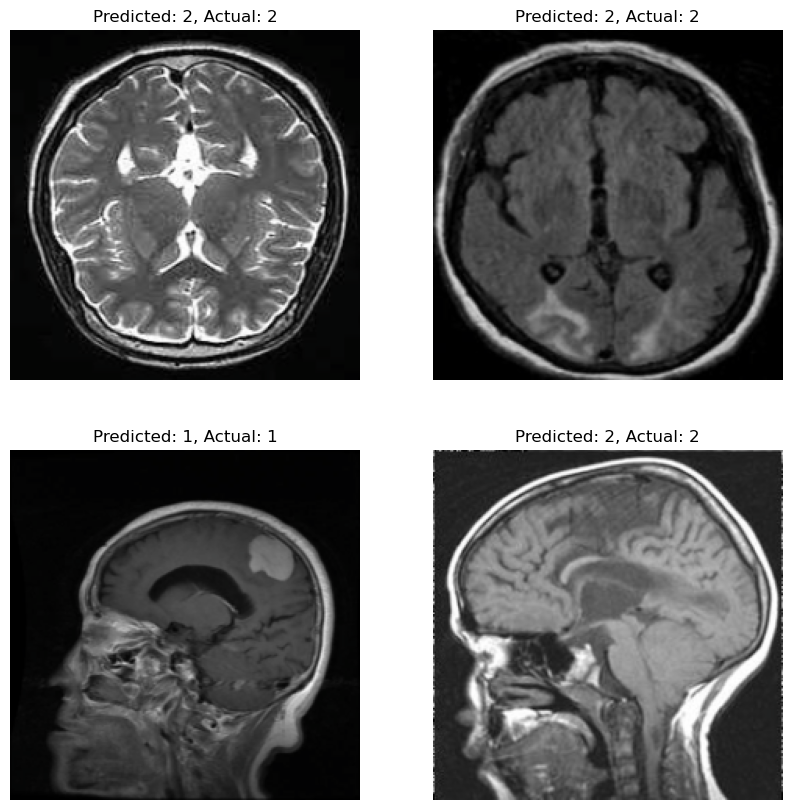

In [21]:
# 4 random image in test data
test_images, test_labels = next(iter(test_loader))
images = test_images[:4]
labels = test_labels[:4]

# Get the model predictions
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# predicted and actual labels
plt.figure(figsize=(10, 10))

for i in range(4):
    image = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    image = np.clip(image, 0, 1)  # Clip values to be between 0 and 1 for display
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(f'Predicted: {preds[i].item()}, Actual: {labels[i].item()}')
    plt.axis('off')

plt.show()


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch

# List of class names
class_names = train_dataset.dataset.classes

# Initialize lists to hold all the labels and predictions
all_labels = []
all_preds = []

# Evaluate the model on the test data
with torch.no_grad():  # Disable gradient calculation 
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Store the labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Generate the classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.90      0.91       270
  meningioma       0.89      0.85      0.87       284
     notumor       0.96      0.98      0.97       285
   pituitary       0.94      0.97      0.95       304

    accuracy                           0.93      1143
   macro avg       0.93      0.93      0.93      1143
weighted avg       0.93      0.93      0.93      1143



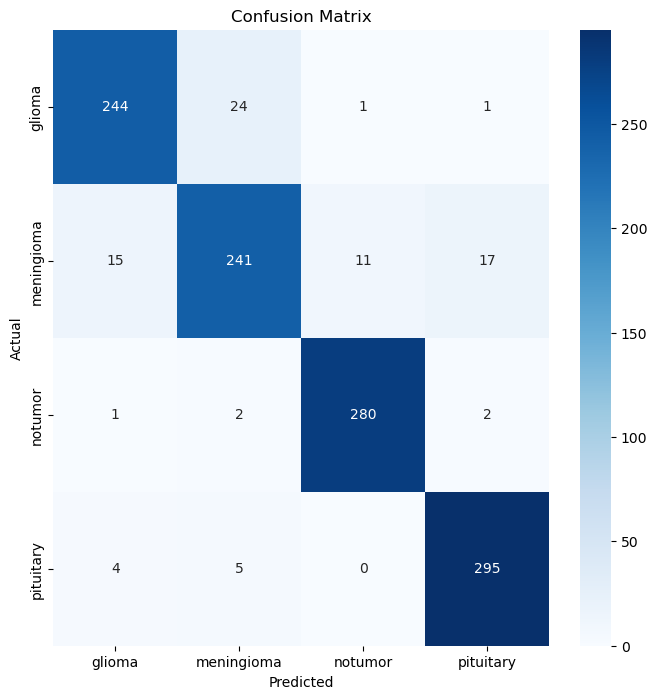

In [24]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()